# Step 0: Imports

Question: 

- Do the attention heads learn to attend to the same positional encodings
- do interp -- what is it doing? can we figure out?
- update: I think we should do interp once it's bigger. 

In [1]:
# using tqdm.auto glitches out collaborative editing
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from math import sqrt
from collections import deque
import os
import random

torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == 'cuda', "CUDA is not available. Please check your GPU setup."

In [2]:
# VTXS numbers here are inclusive
MIN_VTXS = 3
MAX_VTXS = 31
MAX_TUNE_VTXS = 15 # 15
AVG_DEG = 2
SEQ_LEN = MAX_VTXS + 1 # means 32 edges, final token is the target vertex
PAD_TOKEN = 0
# vertices are labelled 1,2,...,63
# we also have a padding token which is 0.

# Step 1: Generate synthetic data

In [4]:
# original task data
# the data will be edge lists
# like this: [1 3 1 5 2 4 0 0 0 0 2]
# this represents edges (1,3), (1,5) (2,4)
# (the zeros are just padding tokens)
# the final 2 means which vertex we're going to 

# the label is the shortest distance from vtx 1 to vtx 2
# or "number of vertices" if no path exists

def random_graph(n):
    edge_list = []
    adjacencies = [set() for _ in range(n+1)]
    indices = [random.randint(1, n) for _ in range(AVG_DEG * n)]
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            edge_list += [min(u,v),max(u,v)]
            adjacencies[u].add(v)
            adjacencies[v].add(u)
    edge_list += [PAD_TOKEN]*(2*SEQ_LEN-1-len(edge_list))
    return edge_list, adjacencies

"""
input: G, represented as an adjacency list
output: [number of vertices]+[d(1,i) for i in range(n)] if target=None
if target is set to some value, then we instead just output that specific distance
"""
def SSSP(n, G, target=2):
    dist = [n for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == n:
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    return dist[target]
    if target is not None:
        return dist[target]
    else:
        return dist

def mkbatch(size):
    graphs1 = []
    distance1 = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_VTXS)
        edge_list, adj_list = random_graph(n)
        dist = SSSP(n, adj_list)
        edge_list[-1] = 2 # target token
        graphs1.append(edge_list)
        distance1.append(dist)
    
    data = torch.tensor(graphs1, device=device)
    labels = torch.tensor(distance1, dtype=torch.bfloat16, device=device)
    padding = data == PAD_TOKEN
    return data, labels, padding

def vertices_on_shortest_12_path(n, G, target=2):
    dist = [n for _ in G]
    parent = [-1 for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == n:
                parent[x] = vtx
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    path = [x]
                    while parent[x] != -1:
                        x = parent[x]
                        path.append(x)
                    return list(reversed(path))
    return []

def mktunebatch(size):
    graphs = []
    distance = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_TUNE_VTXS)
        while True:
            edge_list, adj_list = random_graph(n)
            path = vertices_on_shortest_12_path(n, adj_list)
            if len(path) > 1:
                target_vtx_idx = random.randrange(1, len(path))
                target_vtx = path[target_vtx_idx]
                edge_list[-1] = target_vtx
                graphs.append(edge_list)
                distance.append(target_vtx_idx)
                break
    
    data = torch.tensor(graphs, device=device)
    labels = torch.tensor(distance, dtype=torch.bfloat16, device=device)
    padding = data == PAD_TOKEN
    return data, labels, padding

In [5]:
mkbatch(5)

(tensor([[ 1,  4,  8,  9,  5,  8,  4, 22,  3, 18, 14, 19,  1,  2,  3,  7,  8, 17,
           1, 20,  7, 18, 21, 23, 18, 23,  8, 14, 15, 19,  1,  9,  6, 23, 11, 14,
           5,  9,  7, 11,  3,  4,  4, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  2],
         [ 2,  9, 15, 18,  4, 13,  3, 18, 10, 21, 12, 20,  7, 19,  2,  3,  8, 22,
           3, 10,  4,  8,  9, 13, 15, 21,  6, 12,  7, 22,  9, 22,  3, 21, 20, 21,
           6, 18,  6,  8, 13, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  2],
         [ 9, 11,  4, 11,  1,  6,  1,  4,  6,  7,  2,  5,  4, 10,  4,  6,  8, 11,
           7, 11,  3,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  2],
         [ 3,  4,  5, 10,  7, 10,  6,  7,  3,  4,  8,  9,  1,  2,  2,  3,  3, 11,
           7, 11,  0,  0,  0,  0,  0,  

(array([320.,   0., 310.,   0., 264.,   0., 178.,   0., 119.,   0.,  90.,
          0.,  69.,   0.,  42.,   0.,   0.,  39.,   0.,  30.,   0.,  30.,
          0.,  31.,   0.,  26.,   0.,  28.,   0.,  27.,   0.,   0.,  20.,
          0.,  30.,   0.,  29.,   0.,  26.,   0.,  20.,   0.,  30.,   0.,
         34.,   0.,  23.,   0.,   0.,  35.,   0.,  29.,   0.,  17.,   0.,
         26.,   0.,  33.,   0.,  35.,   0.,  32.,   0.,  26.]),
 array([ 1.     ,  1.46875,  1.9375 ,  2.40625,  2.875  ,  3.34375,
         3.8125 ,  4.28125,  4.75   ,  5.21875,  5.6875 ,  6.15625,
         6.625  ,  7.09375,  7.5625 ,  8.03125,  8.5    ,  8.96875,
         9.4375 ,  9.90625, 10.375  , 10.84375, 11.3125 , 11.78125,
        12.25   , 12.71875, 13.1875 , 13.65625, 14.125  , 14.59375,
        15.0625 , 15.53125, 16.     , 16.46875, 16.9375 , 17.40625,
        17.875  , 18.34375, 18.8125 , 19.28125, 19.75   , 20.21875,
        20.6875 , 21.15625, 21.625  , 22.09375, 22.5625 , 23.03125,
        23.5    , 23.9

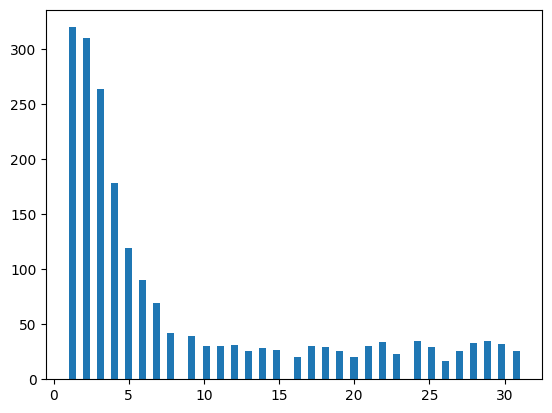

In [6]:
plt.hist(mkbatch(2048)[1].to(torch.float32).cpu(), bins=64)

(array([1289.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  477.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  192.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,   55.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,   28.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    5.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           2.]),
 array([1.     , 1.09375, 1.1875 , 1.28125, 1.375  , 1.46875, 1.5625 ,
        1.65625, 1.75   , 1.84375, 1.9375 , 2.03125, 2.125  , 2.21875,
        2.3125 , 2.40625, 2.5    , 2.59375, 2.6875 , 2.78125, 2.875  ,
        2.96875, 3.0625 , 3.15625, 3.25   , 3.34375, 3.4375 , 3.53125,
        3.625  , 3.71875, 3.8125 , 3.90625, 4.     , 4.09375, 4.1875 ,
        4.28125, 4.375  , 4.46875, 4.5625 , 4.65625, 4.75   , 4.84375,
        4.9375 , 5.03125, 5.125  , 5.21875, 5.3125 , 5.40625

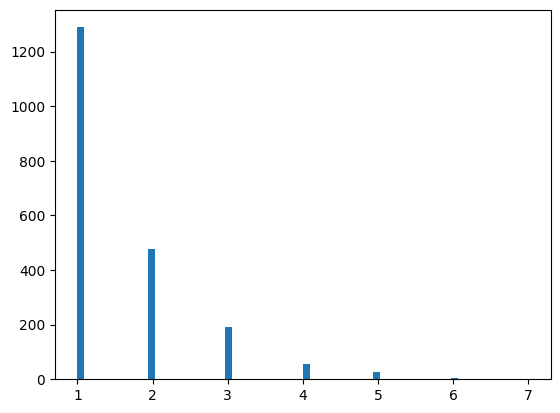

In [7]:
plt.hist(mktunebatch(2048)[1].to(torch.float32).cpu(), bins=64)

In [9]:
# import pickle

# graphs, labels, _ = mkbatch(3*10**5)

# data = {
#     "data": graphs,
#     "labels": labels
# }

# with open('data.pkl', 'wb') as file:
#     pickle.dump(data, file)

# Step 2: Define Transformer Model

In [10]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, output_dim, num_heads, num_layers, seq_len, dropout):
        super().__init__()
        self.model_dim = model_dim
        self.embedding = nn.Embedding(input_dim, model_dim // 2, dtype=torch.bfloat16)
        # # seq_len is odd
        # self.fancy_encoding = torch.repeat_interleave(torch.rand((1, seq_len // 2 + 1, model_dim // 2), device=device, dtype=torch.bfloat16), 2, dim=1)
        # # cut off last element since the target vertex is not repeated
        # self.fancy_encoding = self.fancy_encoding[:, :seq_len, :]
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                                   dim_feedforward=model_dim*4,
                                                   dropout=dropout, batch_first=True, dtype=torch.bfloat16)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(model_dim, output_dim, dtype=torch.bfloat16)

    def forward(self, src, key_padding_mask):
        batch_sz = src.size(0)
        embed = torch.cat((self.embedding(src[:,:-1:2]), self.embedding(src[:,1::2])), dim=2)
        last_dude = torch.cat((self.embedding(src[:,-1:]), torch.ones((batch_sz, 1, self.model_dim // 2), dtype=torch.bfloat16, device=device)), dim=2)
        final_embed = torch.cat((embed, last_dude), dim=1)
        output = self.transformer_encoder(final_embed, src_key_padding_mask=key_padding_mask[:, ::2])
        return self.fc_out(output[:, -1, :])

# Step 3: Make Model

In [11]:
# PARAMS
VOCAB_SIZE = 1 + MAX_VTXS # one more than the max number of vertices
MODEL_DIM = 64 # Dimension of model (embedding and transformer)
NEPOCHS = 1000
BSZ = 2**14 # Batch size
BPE = 32 # Batches per epoch
LR = 5e-5
WD = 1e-5
NHEADS = 4
NLAYERS = 16
DROPOUT = 0 # 0.2
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
                         output_dim=1, num_heads=NHEADS,
                         num_layers=NLAYERS, seq_len=SEQ_LEN,
                         dropout=DROPOUT).to(device)
# model = torch.compile(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training data: {NEPOCHS*BSZ*BPE//10**6}M")
print(f"Trainable parameters in the model: {trainable_params//1000}K")

Training data: 524M
Trainable parameters in the model: 800K


In [121]:
# from torch.utils.data import DataLoader, TensorDataset

# with open("data.pkl", "rb") as f:
#     pickled_stuff = pickle.load(f)

# data = pickled_stuff["data"].to(device)
# label = pickled_stuff["labels"].to(device)
# padding_mask = (data == PAD_TOKEN).bool().to(device)
# dataset = TensorDataset(data, label, padding_mask)
# # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [.9, .1])
# train_loader = DataLoader(dataset, batch_size=BSZ, shuffle=True)

In [12]:
# figure out if it's doing better on short paths
def evaluate_short():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = mkbatch(BSZ)
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output[batch_labels == 1].squeeze(1), batch_labels[batch_labels==1])
    return loss.item()

# Step 4: Train the Model for the first task

In [13]:
def evaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = mkbatch(BSZ)
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

In [ ]:
train_err = []
test_err = []

# clear loss file
open('loss', 'w').close()

for epoch in range(NEPOCHS):
    model.train()
    train_loss = 0
    for i in tqdm(range(BPE)):
        batch_src, batch_labels, batch_padding_mask = mkbatch(BSZ)
    # for batch_src, batch_labels, batch_padding_mask in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        train_loss += loss.item() / BPE
        loss.backward()
        optimizer.step()

    test_loss = evaluate()
    test_short_loss = evaluate_short()
    
    test_err.append(test_loss)
    train_err.append(train_loss)
    with open('loss', 'a') as f:
        f.write(f"{train_loss} {test_loss}\n")
    print(f"Epoch {epoch + 1}/{NEPOCHS} \t Train Err: {train_loss:.4f} \t Test Err: {test_loss:.4f}, Test short loss: {test_short_loss:.4f}")
    
    if epoch % 100 == 99:
        torch.save(model.state_dict(), f"model_weights_{epoch}.pth")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.30it/s]


Epoch 1/1000 	 Train Err: 149.6562 	 Test Err: 137.0000, Test short loss: 0.3164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.41it/s]


Epoch 2/1000 	 Train Err: 129.4688 	 Test Err: 120.0000, Test short loss: 0.4512


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.39it/s]


Epoch 3/1000 	 Train Err: 116.1719 	 Test Err: 110.5000, Test short loss: 2.2500


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.38it/s]


Epoch 4/1000 	 Train Err: 107.9375 	 Test Err: 104.0000, Test short loss: 4.0625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.37it/s]


Epoch 5/1000 	 Train Err: 103.0938 	 Test Err: 102.0000, Test short loss: 5.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.38it/s]


Epoch 6/1000 	 Train Err: 99.9531 	 Test Err: 99.0000, Test short loss: 6.6250


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.41it/s]


Epoch 7/1000 	 Train Err: 99.0469 	 Test Err: 101.0000, Test short loss: 7.2188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.39it/s]


Epoch 8/1000 	 Train Err: 97.8594 	 Test Err: 97.5000, Test short loss: 7.6250


 44%|██████████████████████████████████████████████████████████████████                                                                                     | 14/32 [00:05<00:07,  2.41it/s]

In [125]:
# """
# Now let's figure out what it's doing. 

# step 1: figure out what people are attending to 
# """

# example_graph, answer, padding = mkbatch(1)
# sentance_embeddings = model.full_embedding(example_graph)[0,:,:][example_graph.flatten() != 0]
# WQ,WK,WV = torch.split(model.transformer_encoder.layers[0].self_attn.in_proj_weight, (MODEL_DIM, MODEL_DIM, MODEL_DIM))

# Q = sentance_embeddings@WQ
# K = sentance_embeddings@WK

# raw_scores = Q @ K.T / sqrt(MODEL_DIM)
# soft = torch.softmax(raw_scores, dim=-1).detach().cpu().to(float).numpy()
# plt.imshow(soft)
# plt.show()

# print(example_graph)

# print(Q)

In [ ]:
plt.suptitle('MSE vs Epochs')
plt.plot(train_err, label='Train', color='blue')
plt.plot(test_err, label='Test', color='red')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
batch_src, batch_labels, batch_padding_mask = mkbatch(4096)
output = model(batch_src, batch_padding_mask)
batch_src[0], batch_labels[0], output[0]
plt.scatter(batch_labels.detach().to(torch.float16).cpu().numpy().flatten(), output.detach().to(torch.float16).cpu().numpy().flatten())
plt.show()

# Step 5: Fine Tune

In [ ]:
N_TUNE_EPOCHS = 100
TUNE_LR = 1e-5
TUNE_WD = 1e-5

tune_criterion = nn.MSELoss()
tune_optimizer = torch.optim.Adam(model.parameters(), lr=TUNE_LR, weight_decay=TUNE_WD)

In [ ]:
def tuneevaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = mktunebatch(BSZ)
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

In [ ]:
tune_train_err = []
tune_test_err = []

# clear loss file
open('tune_loss', 'w').close()

for epoch in range(N_TUNE_EPOCHS):
    model.train()
    train_loss = 0
    for i in tqdm(range(BPE)):
        batch_src, batch_labels, batch_padding_mask = mktunebatch(BSZ)
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        train_loss += loss.item() / BPE
        loss.backward()
        optimizer.step()

    test_loss = tuneevaluate()
    
    tune_test_err.append(test_loss)
    tune_train_err.append(train_loss)
    with open('tune_loss', 'a') as f:
        f.write(f"{train_loss} {test_loss}\n")
    print(f"Epoch {epoch + 1}/{NEPOCHS} \t Train Err: {train_loss:.4f} \t Test Err: {test_loss:.4f}")

    if epoch % 10 == 9:
        torch.save(model.state_dict(), f"tune_model_weights_{epoch}.pth")

In [ ]:
plt.suptitle('MSE vs Epochs')
plt.plot(tune_train_err, label='Train', color='blue')
plt.plot(tune_test_err, label='Test', color='red')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
batch_src, batch_labels, batch_padding_mask = mktunebatch(2048)
output = model(batch_src, batch_padding_mask)
batch_src[0], batch_labels[0], output[0]
plt.scatter(batch_labels.detach().to(torch.float16).cpu().numpy().flatten(), output.detach().to(torch.float16).cpu().numpy().flatten())

# Step 6: Test generalization